<a href="https://colab.research.google.com/github/manidumre/Master_Thesis/blob/GAN/ACGAN_Dataset2_Original_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
print(sys.version)

3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0]


In [2]:
import time
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
#tf.config.set_per_process_memory_growth(True)
import pickle
import collections
from collections import defaultdict
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, load_model
from keras.layers import Input, Dense, Conv2D, LeakyReLU, Dropout, Flatten, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import BatchNormalization, Embedding, Reshape, Activation
from keras.layers import Concatenate, Conv2DTranspose, multiply, UpSampling2D
from keras.initializers import RandomNormal
from keras.optimizers import Adam
from keras.utils import Progbar
from keras.metrics import *
from keras import backend as K
import cv2
import os
import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
from __future__ import print_function
#%matplotlib inline
import argparse
import random
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from torchvision.utils import save_image
import cv2
import glob
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
!pip install jovian opendatasets --upgrade --quiet
!pip install -q kaggle
import urllib.request
import opendatasets as od
from torchvision.utils import make_grid
%matplotlib inline
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
import shutil
import torch.nn.functional as F
# Authenticate and create the PyDrive client
gauth = GoogleAuth()
drive = GoogleDrive(gauth)
from torchvision.transforms import ToTensor
from skimage.metrics import structural_similarity as ssim
from torchvision.models import inception_v3
from scipy.linalg import sqrtm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.6/68.6 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [3]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available and will be used.")
else:
    device = torch.device("cpu")
    print("GPU is not available. Switching to CPU.")

print("Device:", device)


GPU is available and will be used.
Device: cuda


# Data Loader

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !pip install opendatasets --upgrade --quiet
# import opendatasets as od
# dataset_url = 'https://www.kaggle.com/datasets/anasmohammedtahir/covidqu'
# !cp -r "/content/drive/MyDrive/Mani Thesis/Code/kaggle.json" "/content"
# od.download(dataset_url, force=True)

100%|██████████| 1.15G/1.15G [00:14<00:00, 88.3MB/s]


In [5]:
!pip install opendatasets --upgrade --quiet
import opendatasets as od
dataset_url = 'https://www.kaggle.com/datasets/nimuchaudhary/images-10-positive'
!cp -r "/content/drive/MyDrive/Mani Thesis/Code/kaggle.json" "/content"
od.download(dataset_url, force=True)

100%|██████████| 681M/681M [00:46<00:00, 15.4MB/s]


In [ ]:
shutil.rmtree('/content/covidqu/Infection Segmentation Data')
os.remove('/content/covidqu/COVID-QU-Ex dataset.txt')

  Training Dataset


In [ ]:
# source_folder_covid = '/content/covidqu/Infection Segmentation Data/Infection Segmentation Data/Train/COVID-19/images'
# destination_folder_covid = '/content/covidqu/Infection Segmentation Data/Infection Segmentation Data/Train/COVID-19'

source_folder_covid = '/content/covidqu/Lung Segmentation Data/Lung Segmentation Data/Train/COVID-19/images'
destination_folder_covid = '/content/covidqu/Lung Segmentation Data/Lung Segmentation Data/Train/COVID-19'


files = os.listdir(source_folder_covid)

for file in files:
    source_path = os.path.join(source_folder_covid, file)
    destination_path = os.path.join(destination_folder_covid, file)
    shutil.move(source_path, destination_path)

# source_folder_non_Covid = '/content/covidqu/Infection Segmentation Data/Infection Segmentation Data/Train/Non-COVID/images'
# destination_folder_non_Covid = '/content/covidqu/Infection Segmentation Data/Infection Segmentation Data/Train/Non-COVID'

source_folder_non_Covid = '/content/covidqu/Lung Segmentation Data/Lung Segmentation Data/Train/Non-COVID/images'
destination_folder_non_Covid = '/content/covidqu/Lung Segmentation Data/Lung Segmentation Data/Train/Non-COVID'

# Get the list of files in the source folder
files = os.listdir(source_folder_non_Covid)

# Move each file to the destination folder
for file in files:
    source_path = os.path.join(source_folder_non_Covid, file)
    destination_path = os.path.join(destination_folder_non_Covid, file)
    shutil.move(source_path, destination_path)

##For Normal Image
# source_folder_Normal = '/content/covidqu/Infection Segmentation Data/Infection Segmentation Data/Train/Normal/images'
# destination_folder_Normal = '/content/covidqu/Infection Segmentation Data/Infection Segmentation Data/Train/Normal'

source_folder_Normal = '/content/covidqu/Lung Segmentation Data/Lung Segmentation Data/Train/Normal/images'
destination_folder_Normal = '/content/covidqu/Lung Segmentation Data/Lung Segmentation Data/Train/Normal'
# Get the list of files in the source folder
files = os.listdir(source_folder_Normal)

# Move each file to the destination folder
for file in files:
    source_path = os.path.join(source_folder_Normal, file)
    destination_path = os.path.join(destination_folder_Normal, file)
    shutil.move(source_path, destination_path)


####For Testing Dataset

In [ ]:

# source_folder_covid = '/content/covidqu/Infection Segmentation Data/Infection Segmentation Data/Test/COVID-19/images'
# destination_folder_covid = '/content/covidqu/Infection Segmentation Data/Infection Segmentation Data/Test/COVID-19'

source_folder_covid = '/content/covidqu/Lung Segmentation Data/Lung Segmentation Data/Test/COVID-19/images'
destination_folder_covid = '/content/covidqu/Lung Segmentation Data/Lung Segmentation Data/Test/COVID-19'

# Get the list of files in the source folder
files = os.listdir(source_folder_covid)

# Move each file to the destination folder
for file in files:
    source_path = os.path.join(source_folder_covid, file)
    destination_path = os.path.join(destination_folder_covid, file)
    shutil.move(source_path, destination_path)

#for non covid
# source_folder_non_Covid = '/content/covidqu/Infection Segmentation Data/Infection Segmentation Data/Test/Non-COVID/images'
# destination_folder_non_Covid = '/content/covidqu/Infection Segmentation Data/Infection Segmentation Data/Test/Non-COVID'

source_folder_non_Covid = '/content/covidqu/Lung Segmentation Data/Lung Segmentation Data/Test/Non-COVID/images'
destination_folder_non_Covid = '/content/covidqu/Lung Segmentation Data/Lung Segmentation Data/Test/Non-COVID'


# Get the list of files in the source folder
files = os.listdir(source_folder_non_Covid)

# Move each file to the destination folder
for file in files:
    source_path = os.path.join(source_folder_non_Covid, file)
    destination_path = os.path.join(destination_folder_non_Covid, file)
    shutil.move(source_path, destination_path)

##For Normal Image
# source_folder_Normal = '/content/covidqu/Infection Segmentation Data/Infection Segmentation Data/Test/Normal/images'
# destination_folder_Normal = '/content/covidqu/Infection Segmentation Data/Infection Segmentation Data/Test/Normal'

source_folder_Normal = '/content/covidqu/Lung Segmentation Data/Lung Segmentation Data/Test/Normal/images'
destination_folder_Normal = '/content/covidqu/Lung Segmentation Data/Lung Segmentation Data/Test/Normal'


# Get the list of files in the source folder
files = os.listdir(source_folder_Normal)

# Move each file to the destination folder
for file in files:
    source_path = os.path.join(source_folder_Normal, file)
    destination_path = os.path.join(destination_folder_Normal, file)
    shutil.move(source_path, destination_path)


####For Validation Dataset

In [ ]:
# source_folder_covid = '/content/covidqu/Infection Segmentation Data/Infection Segmentation Data/Val/COVID-19/images'
# destination_folder_covid = '/content/covidqu/Infection Segmentation Data/Infection Segmentation Data/Val/COVID-19'

source_folder_covid = '/content/covidqu/Lung Segmentation Data/Lung Segmentation Data/Val/COVID-19/images'
destination_folder_covid = '/content/covidqu/Lung Segmentation Data/Lung Segmentation Data/Val/COVID-19/'

# Get the list of files in the source folder
files = os.listdir(source_folder_covid)

# Move each file to the destination folder
for file in files:
    source_path = os.path.join(source_folder_covid, file)
    destination_path = os.path.join(destination_folder_covid, file)
    shutil.move(source_path, destination_path)

#for non covid
# source_folder_non_Covid = '/content/covidqu/Infection Segmentation Data/Infection Segmentation Data/Val/Non-COVID/images'
# destination_folder_non_Covid = '/content/covidqu/Infection Segmentation Data/Infection Segmentation Data/Val/Non-COVID'

# source_folder_non_Covid = '/content/covidqu/Infection Segmentation Data/Infection Segmentation Data/Val/Non-COVID/images'
source_folder_covid = '/content/covidqu/Lung Segmentation Data/Lung Segmentation Data/Val/Non-COVID/images'
destination_folder_non_Covid = '/content/covidqu/Lung Segmentation Data/Lung Segmentation Data/Val/Non-COVID'


# Get the list of files in the source folder
files = os.listdir(source_folder_non_Covid)

# Move each file to the destination folder
for file in files:
    source_path = os.path.join(source_folder_non_Covid, file)
    destination_path = os.path.join(destination_folder_non_Covid, file)
    shutil.move(source_path, destination_path)

##For Normal Image
# source_folder_Normal = '/content/covidqu/Infection Segmentation Data/Infection Segmentation Data/Val/Normal/images'
# destination_folder_Normal = '/content/covidqu/Infection Segmentation Data/Infection Segmentation Data/Val/Normal'

source_folder_Normal = '/content/covidqu/Lung Segmentation Data/Lung Segmentation Data/Val/Normal/images'
destination_folder_Normal = '/content/covidqu/Lung Segmentation Data/Lung Segmentation Data/Val/Normal'

# Get the list of files in the source folder
files = os.listdir(source_folder_Normal)

# Move each file to the destination folder
for file in files:
    source_path = os.path.join(source_folder_Normal, file)
    destination_path = os.path.join(destination_folder_Normal, file)
    shutil.move(source_path, destination_path)


In [ ]:
# shutil.rmtree('/content/covidqu/Infection Segmentation Data/Infection Segmentation Data/Train/COVID-19/images')
# shutil.rmtree('/content/covidqu/Infection Segmentation Data/Infection Segmentation Data/Train/COVID-19/infection masks')
# shutil.rmtree('/content/covidqu/Infection Segmentation Data/Infection Segmentation Data/Train/COVID-19/lung masks')
# shutil.rmtree('/content/covidqu/Infection Segmentation Data/Infection Segmentation Data/Train/Non-COVID/images')
# shutil.rmtree('/content/covidqu/Infection Segmentation Data/Infection Segmentation Data/Train/Non-COVID/infection masks')
# shutil.rmtree('/content/covidqu/Infection Segmentation Data/Infection Segmentation Data/Train/Non-COVID/lung masks')
# shutil.rmtree('/content/covidqu/Infection Segmentation Data/Infection Segmentation Data/Train/Normal/images')
# shutil.rmtree('/content/covidqu/Infection Segmentation Data/Infection Segmentation Data/Train/Normal/infection masks')
# shutil.rmtree('/content/covidqu/Infection Segmentation Data/Infection Segmentation Data/Train/Normal/lung masks')

shutil.rmtree('/content/covidqu/Lung Segmentation Data/Lung Segmentation Data/Train/COVID-19/images')
shutil.rmtree('/content/covidqu/Lung Segmentation Data/Lung Segmentation Data/Train/COVID-19/lung masks')
shutil.rmtree('/content/covidqu/Lung Segmentation Data/Lung Segmentation Data/Train/Non-COVID/images')
shutil.rmtree('/content/covidqu/Lung Segmentation Data/Lung Segmentation Data/Train/Non-COVID/lung masks')
shutil.rmtree('/content/covidqu/Lung Segmentation Data/Lung Segmentation Data/Train/Normal/images')
shutil.rmtree('/content/covidqu/Lung Segmentation Data/Lung Segmentation Data/Train/Normal/lung masks')

In [ ]:
# shutil.rmtree('/content/covidqu/Infection Segmentation Data/Infection Segmentation Data/Test/COVID-19/images')
# shutil.rmtree('/content/covidqu/Infection Segmentation Data/Infection Segmentation Data/Test/COVID-19/infection masks')
# shutil.rmtree('/content/covidqu/Infection Segmentation Data/Infection Segmentation Data/Test/COVID-19/lung masks')
# shutil.rmtree('/content/covidqu/Infection Segmentation Data/Infection Segmentation Data/Test/Non-COVID/images')
# shutil.rmtree('/content/covidqu/Infection Segmentation Data/Infection Segmentation Data/Test/Non-COVID/infection masks')
# shutil.rmtree('/content/covidqu/Infection Segmentation Data/Infection Segmentation Data/Test/Non-COVID/lung masks')
# shutil.rmtree('/content/covidqu/Infection Segmentation Data/Infection Segmentation Data/Test/Normal/images')
# shutil.rmtree('/content/covidqu/Infection Segmentation Data/Infection Segmentation Data/Test/Normal/infection masks')
# shutil.rmtree('/content/covidqu/Infection Segmentation Data/Infection Segmentation Data/Test/Normal/lung masks')



shutil.rmtree('/content/covidqu/Lung Segmentation Data/Lung Segmentation Data/Test/COVID-19/images')
shutil.rmtree('/content/covidqu/Lung Segmentation Data/Lung Segmentation Data/Test/COVID-19/lung masks')
shutil.rmtree('/content/covidqu/Lung Segmentation Data/Lung Segmentation Data/Test/Non-COVID/images')
shutil.rmtree('/content/covidqu/Lung Segmentation Data/Lung Segmentation Data/Test/Non-COVID/lung masks')
shutil.rmtree('/content/covidqu/Lung Segmentation Data/Lung Segmentation Data/Test/Normal/images')
shutil.rmtree('/content/covidqu/Lung Segmentation Data/Lung Segmentation Data/Test/Normal/lung masks')


In [ ]:
# shutil.rmtree('/content/covidqu/Infection Segmentation Data/Infection Segmentation Data/Val/COVID-19/images')
# shutil.rmtree('/content/covidqu/Infection Segmentation Data/Infection Segmentation Data/Val/COVID-19/infection masks')
# shutil.rmtree('/content/covidqu/Infection Segmentation Data/Infection Segmentation Data/Val/COVID-19/lung masks')
# shutil.rmtree('/content/covidqu/Infection Segmentation Data/Infection Segmentation Data/Val/Non-COVID/images')
# shutil.rmtree('/content/covidqu/Infection Segmentation Data/Infection Segmentation Data/Val/Non-COVID/infection masks')
# shutil.rmtree('/content/covidqu/Infection Segmentation Data/Infection Segmentation Data/Val/Non-COVID/lung masks')
# shutil.rmtree('/content/covidqu/Infection Segmentation Data/Infection Segmentation Data/Val/Normal/images')
# shutil.rmtree('/content/covidqu/Infection Segmentation Data/Infection Segmentation Data/Val/Normal/infection masks')
# shutil.rmtree('/content/covidqu/Infection Segmentation Data/Infection Segmentation Data/Val/Normal/lung masks')


shutil.rmtree('/content/covidqu/Lung Segmentation Data/Lung Segmentation Data/Val/COVID-19/images')
shutil.rmtree('/content/covidqu/Lung Segmentation Data/Lung Segmentation Data/Val/COVID-19/lung masks')
shutil.rmtree('/content/covidqu/Lung Segmentation Data/Lung Segmentation Data/Val/Non-COVID/images')
shutil.rmtree('/content/covidqu/Lung Segmentation Data/Lung Segmentation Data/Val/Non-COVID/lung masks')
shutil.rmtree('/content/covidqu/Lung Segmentation Data/Lung Segmentation Data/Val/Normal/images')
shutil.rmtree('/content/covidqu/Lung Segmentation Data/Lung Segmentation Data/Val/Normal/lung masks')

Set batch size, image size and path

In [ ]:
batch_size=64
img_size=112
# set training, validation, and testing paths
# training_path = os.path.join(f'/content/covidqu/Infection Segmentation Data/Infection Segmentation Data/Train')
# val_path = os.path.join(f'/content/covidqu/Infection Segmentation Data/Infection Segmentation Data/Val')
# testing_path = os.path.join(f'/content/covidqu/Infection Segmentation Data/Infection Segmentation Data/Test')

training_path = os.path.join(f'/content/covidqu/Lung Segmentation Data/Lung Segmentation Data/Train')
val_path = os.path.join(f'/content/covidqu/Lung Segmentation Data/Lung Segmentation Data/Val')
testing_path = os.path.join(f'/content/covidqu/Lung Segmentation Data/Lung Segmentation Data/Test')

In [ ]:
import os

training_path = '/content/covidqu/Lung Segmentation Data/Lung Segmentation Data/Train'
testing_path = '/content/covidqu/Lung Segmentation Data/Lung Segmentation Data/Test'
real_train_data_no = {}

# Function to count the number of files in each subfolder
def count_files_in_subfolders(directory):
    subfolders = [subfolder for subfolder in os.listdir(directory) if os.path.isdir(os.path.join(directory, subfolder))]
    file_counts = {}
    for subfolder in subfolders:
        subfolder_path = os.path.join(directory, subfolder)
        file_counts[subfolder] = len(os.listdir(subfolder_path))
    return file_counts

# Count the number of files in training subfolders
train_file_counts = count_files_in_subfolders(training_path)
print("Training subfolder file counts:")
for subfolder, count in train_file_counts.items():
    print(f"{subfolder}: {count} images")
    real_train_data_no[subfolder] = count

# Count the number of files in testing subfolders
test_file_counts = count_files_in_subfolders(testing_path)
print("Testing subfolder file counts:")
for subfolder, count in test_file_counts.items():
    print(f"{subfolder}: {count} images")
print(real_train_data_no)
# Print the dictionary containing the file counts
print("Real Training Data File Counts:")
print(real_train_data_no['Non-COVID'])
print(real_train_data_no['Normal'])
print(real_train_data_no['COVID-19'])

Training subfolder file counts:
Non-COVID: 7208 images
Normal: 6849 images
COVID-19: 7658 images
Testing subfolder file counts:
Non-COVID: 2253 images
Normal: 2140 images
COVID-19: 2395 images
{'Non-COVID': 7208, 'Normal': 6849, 'COVID-19': 7658}
Real Training Data File Counts:
7208
6849
7658


In [ ]:
train_datagen = ImageDataGenerator(shear_range=0.1,
                                   zoom_range=0.1)

test_datagen = ImageDataGenerator(shear_range=0.1,
                                  zoom_range=0.1)


train_data = train_datagen.flow_from_directory(training_path,
                                               batch_size = batch_size,
                                               target_size = (img_size, img_size),
                                               shuffle = True, class_mode = 'binary', seed = 42)


test_data = test_datagen.flow_from_directory(testing_path, batch_size = batch_size,
                                             target_size = (img_size, img_size),
                                             shuffle = True, class_mode = 'binary', seed = 42)

print(train_data.class_indices)
print(test_data.class_indices)

batchX, batchy = train_data.next()

print('train_batch.shape:', batchX.shape)
print('label_batch.shape', batchy.shape)
print(img_size)

Found 21715 images belonging to 3 classes.
Found 6788 images belonging to 3 classes.
{'COVID-19': 0, 'Non-COVID': 1, 'Normal': 2}
{'COVID-19': 0, 'Non-COVID': 1, 'Normal': 2}
train_batch.shape: (64, 112, 112, 3)
label_batch.shape (64,)
112


In [ ]:
len(train_data)

340

In [ ]:
len(test_data)

107

In [ ]:
def discriminator(input_shape=(112, 112, 3), n_classes = 3):
  def conv_block(input_layer, filter_size, stride):
    x = Conv2D(filter_size, kernel_size = (3,3), padding='same',
                strides=stride, kernel_initializer = RandomNormal(mean = 0.0, stddev = 0.02))(input_layer)
    x = BatchNormalization(momentum = 0.9)(x)
    x = LeakyReLU(alpha = 0.2)(x)
    x = Dropout(0.5)(x)
    return x

  input_img = Input(shape=input_shape)

  x = Conv2D(32, kernel_size = (3, 3), strides = (1, 1), padding='same',
            kernel_initializer = RandomNormal(mean = 0.0, stddev = 0.02))(input_img)
  x = BatchNormalization(momentum = 0.9)(x)
  x = LeakyReLU(alpha = 0.2)(x)
  x = Dropout(0.5)(x)
  x = conv_block(x, 64, (2, 2))
  x = conv_block(x, 128, (2, 2))
  x = conv_block(x, 256, (2, 2))
  x = conv_block(x, 512, (2, 2))
  features = Flatten()(x)
  fake = Dense(1, activation='sigmoid', name='source')(features)
  aux = Dense(n_classes, activation='softmax', name='auxiliary')(features)
  model = Model(inputs = input_img,  outputs = [fake, aux])
  return model

In [ ]:
discriminator_instance = discriminator(input_shape=(112, 112, 3))
discriminator_instance.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 112, 112, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 112, 112, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [ ]:
def generator(latent_dim = 100, n_classes = 3):
    label_input = Input(shape = (1,))
    y = Embedding(n_classes, 100)(label_input)
    n_nodes = 7 * 7
    y = Dense(n_nodes, kernel_initializer = RandomNormal(mean = 0.0, stddev = 0.02))(y)
    y = Reshape((7, 7 ,1))(y)
    print('reshape(final y shape): ', y.shape)
    generator_input = Input(shape = (latent_dim,))
    n_nodes = 1024 * 7 * 7
    gen = Dense(n_nodes,
                kernel_initializer = RandomNormal(mean = 0.0, stddev = 0.02))(generator_input)
    gen = Activation('relu')(gen)
    gen = Reshape((7, 7, 1024))(gen)
    print('Generator noise input: ', gen.shape)
    merge = Concatenate()([gen, y])
    print('Concatenate(generator noise input and y: ', merge.shape)
    gen = Conv2DTranspose(512, kernel_size = (5, 5), strides = (2, 2), padding = "same", kernel_initializer = RandomNormal(mean = 0.0, stddev = 0.02))(merge)
    gen = BatchNormalization(momentum = 0.9)(gen)
    gen = Activation("relu")(gen)
    print("(None, 7, 7, 1024) -> (None, 14, 14, 512): ", gen.shape)
    gen = Conv2DTranspose(256, kernel_size = (5, 5), strides = (2, 2), padding = "same", kernel_initializer = RandomNormal(mean = 0.0, stddev = 0.02))(gen)
    gen = BatchNormalization(momentum = 0.9)(gen)
    gen = Activation("relu")(gen)
    print('(None, 14, 14, 512) -> (None, 28, 28, 256): ', gen.shape)
    gen = Conv2DTranspose(128, kernel_size = (5, 5), strides = (2, 2), padding = "same", kernel_initializer = RandomNormal(mean = 0.0, stddev = 0.02))(gen)
    gen = BatchNormalization(momentum = 0.9)(gen)
    gen = Activation("relu")(gen)
    print('(None, 28, 28, 256) -> (None, 56, 56, 128): ', gen.shape)
    gen = Conv2DTranspose(3, kernel_size = (5, 5), strides = (2, 2), padding = "same", kernel_initializer = RandomNormal(mean = 0.0, stddev = 0.02))(gen)
    out_layer = Activation("tanh")(gen)
    print("(None, 56, 56, 128) -> (None, 112, 112, 3): ", out_layer.shape)
    model = Model(inputs = [generator_input, label_input], outputs = out_layer)
    return model

In [ ]:
generator_instance = generator(latent_dim = 100, n_classes = 3)
generator_instance.summary()

reshape(final y shape):  (None, 7, 7, 1)
Generator noise input:  (None, 7, 7, 1024)
Concatenate(generator noise input and y:  (None, 7, 7, 1025)
(None, 7, 7, 1024) -> (None, 14, 14, 512):  (None, 14, 14, 512)
(None, 14, 14, 512) -> (None, 28, 28, 256):  (None, 28, 28, 256)
(None, 28, 28, 256) -> (None, 56, 56, 128):  (None, 56, 56, 128)
(None, 56, 56, 128) -> (None, 112, 112, 3):  (None, 112, 112, 3)
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                    

In [ ]:
#adam_lr = 0.001
#adam_beta_1 = 0.5

def define_acgan(latent_dim = 100, adam_lr = 0.001, adam_beta_1 = 0.5):


    dis = discriminator()
    dis.compile(
        optimizer=Adam(learning_rate=adam_lr, beta_1=adam_beta_1),
        loss={'source':'binary_crossentropy', 'auxiliary':'sparse_categorical_crossentropy'}
    )

    gen = generator(latent_dim)
    gen.compile(optimizer=Adam(learning_rate=adam_lr, beta_1=adam_beta_1),
                      loss='binary_crossentropy')

    latent = Input(shape=(latent_dim, ), name='latent_noise')
    image_class = Input(shape=(1,), name='image_class')
    print(image_class.dtype)
    fake_img = gen([latent, image_class])
    print('fake image: ', fake_img.shape)
    fake, aux = dis(fake_img)
    combined = Model(inputs=[latent, image_class],
                            outputs=[fake, aux],
                            name='ACGAN')

    combined.compile(
        optimizer=Adam(learning_rate=adam_lr, beta_1=adam_beta_1),
        loss=['binary_crossentropy', 'sparse_categorical_crossentropy']
    )

    combined.summary()
    return combined, dis, gen

In [ ]:
accgan_model = define_acgan(latent_dim=100)

reshape(final y shape):  (None, 7, 7, 1)
Generator noise input:  (None, 7, 7, 1024)
Concatenate(generator noise input and y:  (None, 7, 7, 1025)
(None, 7, 7, 1024) -> (None, 14, 14, 512):  (None, 14, 14, 512)
(None, 14, 14, 512) -> (None, 28, 28, 256):  (None, 28, 28, 256)
(None, 28, 28, 256) -> (None, 56, 56, 128):  (None, 56, 56, 128)
(None, 56, 56, 128) -> (None, 112, 112, 3):  (None, 112, 112, 3)
<dtype: 'float32'>
fake image:  (None, 112, 112, 3)
Model: "ACGAN"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 latent_noise (InputLayer)      [(None, 100)]        0           []                               
                                                                                                  
 image_class (InputLayer)       [(None, 1)]          0           []                               
                                  

In [ ]:
def label_smoothing(vector, max_dev = 0.2):
        d = max_dev * np.random.rand(vector.shape[0],vector.shape[1])
        if vector[0][0] == 0:
            return vector + d
        else:
            return vector - d

def print_logs(metrics_names, train_history, test_history):

    print('{0:<22s} | {1:4s} | {2:15s} | {3:5s}'.format(
        'component', *metrics_names))
    print('-' * 65)

    ROW_FMT = '{0:<22s} | {1:<4.2f} | {2:<15.2f} | {3:<5.2f}'
    print(ROW_FMT.format('generator (train)',
                         *train_history['generator'][-1]))
    print(ROW_FMT.format('generator (test)',
                         *test_history['generator'][-1]))
    print(ROW_FMT.format('discriminator (train)',
                         *train_history['discriminator'][-1]))
    print(ROW_FMT.format('discriminator (test)',
                         *test_history['discriminator'][-1]))


def generate_batch_noise_and_labels(batch_size, latent_dim, n_classes = 3):
    noise = np.random.uniform(-1, 1, (batch_size, latent_dim))
    sampled_labels = np.random.randint(0, n_classes, batch_size)
    return noise, sampled_labels

**IMAGE GERATOR for gif**

In [ ]:
seed_gif_noise, seed_gif_labels = generate_batch_noise_and_labels(batch_size=16, latent_dim=100)

In [ ]:
print(seed_gif_labels)

[0 1 2 1 1 0 2 0 1 0 1 1 0 0 1 0]


##Name Map ko Lagi

In [ ]:
import os
training_dataset_folder = '/content/covidqu/Lung Segmentation Data/Lung Segmentation Data/Train'
# Get the list of folders within the training dataset folder
name_map = [folder for folder in os.listdir(training_dataset_folder) if os.path.isdir(os.path.join(training_dataset_folder, folder))]
name_map

['Non-COVID', 'Normal', 'COVID-19']

In [ ]:
def generate_and_save_images(model, epoch, noise, labels):
  generated_images_sample = model.predict([noise, labels.reshape((-1, 1))], verbose=0)
  norm_image = cv2.normalize((generated_images_sample + 1) * 127.5, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
  norm_img = norm_image.astype(np.uint8)

  fig = plt.figure(figsize=(10, 10))
  for i in range(norm_img.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.title(name_map[labels[i]])
      plt.imshow(norm_img[i,:,:], cmap='gray')
      plt.axis('off')

  plt.savefig('/content/drive/MyDrive/Mani Thesis/Dataset/Fake/Dataset2/ACGAN/images_for_gif/image_at_epoch_{:04d}.png'.format(epoch))
  plt.close()

In [ ]:
np.save('/content/drive/MyDrive/Mani Thesis/SaveDir/Dataset2/seed_gif_noise.npy', seed_gif_noise)
np.save('/content/drive/MyDrive/Mani Thesis/SaveDir/Dataset2/seed_gif_labels.npy', seed_gif_labels)

In [ ]:
nb_epochs = 101
batch_size = 64
latent_dim = 100

nb_batches_train = len(train_data) # number of iterarions per epoch for training
nb_batches_test = len(test_data) # number of iterarions per epoch for testing
# nb_batches_val = len(val_data) # number of iterarions per epoch for validation

save_every_n_epoch = 10 # save the model and history every n epochs
save_images_every_n_epoch = 10

print('Number of epochs: ', nb_epochs)
print('Batch size: ', batch_size)
print('Number of batches per epoch for training: ', nb_batches_train)
print('Number of batches per epoch for testing: ', nb_batches_test)


train_history = defaultdict(list)
test_history = defaultdict(list)
test_accuracy_history = defaultdict(list)

Number of epochs:  101
Batch size:  64
Number of batches per epoch for training:  340
Number of batches per epoch for testing:  107


**Define AC-cGAN**

In [ ]:
combined, dis, gen = define_acgan(latent_dim = latent_dim)

reshape(final y shape):  (None, 7, 7, 1)
Generator noise input:  (None, 7, 7, 1024)
Concatenate(generator noise input and y:  (None, 7, 7, 1025)
(None, 7, 7, 1024) -> (None, 14, 14, 512):  (None, 14, 14, 512)
(None, 14, 14, 512) -> (None, 28, 28, 256):  (None, 28, 28, 256)
(None, 28, 28, 256) -> (None, 56, 56, 128):  (None, 56, 56, 128)
(None, 56, 56, 128) -> (None, 112, 112, 3):  (None, 112, 112, 3)
<dtype: 'float32'>
fake image:  (None, 112, 112, 3)
Model: "ACGAN"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 latent_noise (InputLayer)      [(None, 100)]        0           []                               
                                                                                                  
 image_class (InputLayer)       [(None, 1)]          0           []                               
                                  

**TRAINING**

In [ ]:
# for epoch in range(nb_epochs):
for epoch in range(start_epoch, nb_epochs):

    print('Epoch {} of {}, training ..'.format(epoch + 1, nb_epochs))
    progress_bar = Progbar(target=nb_batches_train)
    epoch_gen_loss = []
    epoch_disc_loss = []
    gen_test_loss = []
    disc_test_loss = []
    disc_real_accuracy = []
    disc_fake_accuracy = []

    if epoch == 0:
        generate_and_save_images(gen, epoch, seed_gif_noise, seed_gif_labels)

    for index, (image_batch, label_batch) in zip(range(nb_batches_train), train_data):
        image_batch = image_batch * (1. / 127.5) - 1
        nb_train = image_batch.shape[0]
        progress_bar.update(index+1)
        noise, sampled_labels = generate_batch_noise_and_labels(nb_train, latent_dim)
        generated_images = gen.predict([noise, sampled_labels.reshape((-1, 1))],  verbose=0)
        X = np.concatenate((image_batch, generated_images))
        valid = label_smoothing(vector = np.ones((nb_train, 1)), max_dev = 0.2)
        fake = label_smoothing(vector = np.zeros((nb_train, 1)), max_dev = 0.2)
        y = np.concatenate((valid, fake), axis = 0)
        aux_y = np.concatenate((label_batch, sampled_labels), axis=0)
        epoch_disc_loss.append(dis.train_on_batch(X, [y, aux_y]))

        noise, sampled_labels = generate_batch_noise_and_labels(2 * nb_train, latent_dim)

        trick = np.ones(2 * nb_train)
        epoch_gen_loss.append(combined.train_on_batch(
            [noise, sampled_labels.reshape((-1, 1))], [trick, sampled_labels]))

    progress_bar = Progbar(target=nb_batches_test)

    print('\nTesting for epoch {}:'.format(epoch + 1))

    for index_1, (test_image_batch, test_label_batch) in zip(range(nb_batches_test), test_data):
        progress_bar.update(index_1+1)
        test_image_batch = test_image_batch * (1. / 127.5) - 1
        nb_test = test_image_batch.shape[0]
        noise, sampled_labels = generate_batch_noise_and_labels(nb_test, latent_dim)
        generated_images = gen.predict(
            [noise, sampled_labels.reshape((-1, 1))], verbose=False
        )

        X = np.concatenate((test_image_batch, generated_images))
        y = np.array([1] * nb_test + [0] * nb_test)
        aux_y = np.concatenate((test_label_batch, sampled_labels), axis=0)
        test_discriminator_loss = dis.evaluate(X, [y, aux_y], verbose = False)
        disc_pred = dis.predict(X, verbose = False)
        acc_real = tf.reduce_mean(tf.cast(K.equal(y[:nb_test], K.round(K.clip(disc_pred[0][:nb_test], 0, 1))), tf.float32)).numpy()
        acc_fake = tf.reduce_mean(tf.cast(K.equal(y[nb_test:], K.round(K.clip(disc_pred[0][nb_test:], 0, 1))), tf.float32)).numpy()

        disc_real_accuracy.append(acc_real)
        disc_fake_accuracy.append(acc_fake)

        disc_test_loss.append(test_discriminator_loss)
        noise, sampled_labels = generate_batch_noise_and_labels(2 * nb_test, latent_dim)
        trick = np.ones(2 * nb_test)
        test_generator_loss = combined.evaluate(
            [noise, sampled_labels.reshape((-1, 1))],
            [trick, sampled_labels], verbose = False
        )
        gen_test_loss.append(test_generator_loss)


    discriminator_train_loss = np.mean(np.array(epoch_disc_loss), axis=0)

    generator_train_loss = np.mean(np.array(epoch_gen_loss), axis=0)

    generator_test_loss = np.mean(np.array(gen_test_loss), axis=0)

    discriminator_test_loss = np.mean(np.array(disc_test_loss), axis=0)

    discriminator_test_accuracy_real = np.mean(np.array(disc_real_accuracy), axis=0)
    discriminator_test_accuracy_fake = np.mean(np.array(disc_fake_accuracy), axis=0)

    train_history['generator'].append(generator_train_loss)
    train_history['discriminator'].append(discriminator_train_loss)

    test_history['generator'].append(generator_test_loss)
    test_history['discriminator'].append(discriminator_test_loss)

    test_accuracy_history['discriminator_real'].append(discriminator_test_accuracy_real)
    test_accuracy_history['discriminator_fake'].append(discriminator_test_accuracy_fake)

    print_logs(dis.metrics_names, train_history, test_history)
    print(f'Test Disc Accuracy of the real images: {discriminator_test_accuracy_real}')
    print(f'Test Disc Accuracy of the fake images: {discriminator_test_accuracy_fake}')

    if ((epoch+1) % save_every_n_epoch == 0) or (epoch == 0):
        gen.save_weights('/content/drive/MyDrive/Mani Thesis/SaveDir/Dataset2/weights/params_generator_epoch_{0:03d}.hdf5'.format(epoch+1), True)
        dis.save_weights('/content/drive/MyDrive/Mani Thesis/SaveDir/Dataset2/weights/params_discriminator_epoch_{0:03d}.hdf5'.format(epoch+1), True)
        pickle.dump({'train': train_history, 'test':test_history, 'accuracy':test_accuracy_history},
            open(f'/content/drive/MyDrive/Mani Thesis/SaveDir/Dataset2/history/acgan_history_{epoch+1}.pkl', 'wb'))

        gen.save('/content/drive/MyDrive/Mani Thesis/SaveDir/Dataset2/full_models/generator_full_model_epoch_{0:03d}.hdf5'.format(epoch+1))
        dis.save('/content/drive/MyDrive/Mani Thesis/SaveDir/Dataset2/full_models/discriminator_full_model_epoch_{0:03d}.hdf5'.format(epoch+1))

    # Images generated every save_every_n_epoch epochs
    if ((epoch+1) % save_images_every_n_epoch == 0) or (epoch == 0):
        generate_and_save_images(gen, epoch + 1, seed_gif_noise, seed_gif_labels)

gen.save_weights(f'/content/drive/MyDrive/Mani Thesis/SaveDir/Dataset2/weights/params_generator_epoch_{nb_epochs}.hdf5', True)
dis.save_weights(f'/content/drive/MyDrive/Mani Thesis/SaveDir/Dataset2/weights/params_discriminator_epoch_{nb_epochs}.hdf5', True)
pickle.dump({'train': train_history, 'test':test_history, 'accuracy':test_accuracy_history},open(f'/content/drive/MyDrive/Mani Thesis/SaveDir/Dataset2/history/acgan_history_{nb_epochs}.pkl', 'wb'))
generate_and_save_images(gen, epoch + 1, seed_gif_noise, seed_gif_labels)
gen.save(f'/content/drive/MyDrive/Mani Thesis/SaveDir/Dataset2/full_models/generator_full_model_epoch_{nb_epochs}.hdf5')
dis.save(f'/content/drive/MyDrive/Mani Thesis/SaveDir/Dataset2/full_models/discriminator_full_model_epoch_{nb_epochs}.hdf5')

Define Start Epoch

In [ ]:
start_epoch = 70 # Write the epoch of the last saved model (cause the epochs start from epoch + 1)
nb_epochs =101

nb_batches_train = len(train_data) # number of iterarions per epoch for training
nb_batches_test = len(test_data) # number of iterarions per epoch for testing
# nb_batches_val = len(val_data) # number of iterarions per epoch for validation


save_every_n_epoch = 10 # save the model and history every n epochs
save_images_every_n_epoch = 10 # save the images every n epochs

print('Number of epochs: ', nb_epochs)
print('Batch size: ', batch_size)
print('Number of batches per epoch for training: ', nb_batches_train)
print('Number of batches per epoch for testing: ', nb_batches_test)

Number of epochs:  101
Batch size:  64
Number of batches per epoch for training:  340
Number of batches per epoch for testing:  107


Load history

In [ ]:
path_hist = f'/content/drive/MyDrive/Mani Thesis/SaveDir/Dataset2/history/acgan_history_{start_epoch}.pkl'
hist = pickle.load(open(path_hist, 'rb'))

test_accuracy_history = defaultdict(list)
test_accuracy_history['discriminator_real'] = hist['accuracy']['discriminator_real']
test_accuracy_history['discriminator_fake'] = hist['accuracy']['discriminator_fake']

train_history = defaultdict(list)
train_history['generator'] = hist['train']['generator']
train_history['discriminator'] = hist['train']['discriminator']

test_history = defaultdict(list)
test_history['generator'] = hist['test']['generator']
test_history['discriminator'] = hist['test']['discriminator']

Import seeds

In [ ]:
seed_gif_noise = np.load('/content/drive/MyDrive/Mani Thesis/SaveDir/Dataset2/seed_gif_noise.npy')
seed_gif_labels = np.load('/content/drive/MyDrive/Mani Thesis/SaveDir/Dataset2/seed_gif_labels.npy')

In [ ]:
print(seed_gif_labels)

[0 1 2 1 1 0 2 0 1 0 1 1 0 0 1 0]


Import models

In [ ]:
path_gen = f"/content/drive/MyDrive/Mani Thesis/SaveDir/Dataset2/full_models/generator_full_model_epoch_0{start_epoch}.hdf5"
path_dis = f"/content/drive/MyDrive/Mani Thesis/SaveDir/Dataset2/full_models/discriminator_full_model_epoch_0{start_epoch}.hdf5"
filename_gen = f"/content/drive/MyDrive/Mani Thesis/SaveDir/Dataset2/weights/params_generator_epoch_0{start_epoch}.hdf5"
filename_dis = f"/content/drive/MyDrive/Mani Thesis/SaveDir/Dataset2/weights/params_discriminator_epoch_0{start_epoch}.hdf5"
generator_instance.load_weights(filename_gen)
discriminator_instance.load_weights(filename_dis)
print(path_dis)
print(nb_epochs)

/content/drive/MyDrive/Mani Thesis/SaveDir/Dataset2/full_models/discriminator_full_model_epoch_070.hdf5
101


In [ ]:
def define_acgan_continue(latent_dim = 100, adam_lr = 0.001, adam_beta_1 = 0.5, path_gen = None, path_dis = None):
    dis = load_model(path_dis, compile = True)
    gen = load_model(path_gen, compile = True)
    latent = Input(shape=(latent_dim, ), name='latent_noise')
    image_class = Input(shape=(1,), name='image_class')
    print(image_class.dtype)
    fake_img = gen([latent, image_class])
    print('fake image: ', fake_img.shape)
    dis.trainable = False
    fake, aux = dis(fake_img)
    combined = Model(inputs=[latent, image_class],
                            outputs=[fake, aux],
                            name='ACGAN')
    combined.compile(
        optimizer=Adam(learning_rate=adam_lr, beta_1=adam_beta_1),
        loss=['binary_crossentropy', 'sparse_categorical_crossentropy']
    )
    combined.summary()
    return combined, dis, gen

In [ ]:
latent_dim=100
combined, dis, gen = define_acgan_continue(latent_dim = latent_dim, path_gen = path_gen, path_dis = path_dis)

<dtype: 'float32'>
fake image:  (None, 112, 112, 3)
Model: "ACGAN"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 latent_noise (InputLayer)      [(None, 100)]        0           []                               
                                                                                                  
 image_class (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 model_6 (Functional)           (None, 112, 112, 3)  22303108    ['latent_noise[0][0]',           
                                                                  'image_class[0][0]']            
                                                                                                  
 model_5 (Functional)           [(None, 1)

Train from start epoch to End epoch,, Again Training

In [ ]:
# start_epoch = 31
# for epoch in range(start_epoch, nb_epochs):
#     print('Epoch {} of {}, training ..'.format(epoch + 1, nb_epochs))
#     progress_bar = Progbar(target=nb_batches_train)
#     epoch_gen_loss = []
#     epoch_disc_loss = []
#     gen_test_loss = []
#     disc_test_loss = []
#     disc_real_accuracy = []
#     disc_fake_accuracy = []

#     if epoch == 0:
#         generate_and_save_images(gen, epoch, seed_gif_noise, seed_gif_labels)

#     for index, (image_batch, label_batch) in zip(range(nb_batches_train), train_data):

#         image_batch = image_batch * (1. / 127.5) - 1
#         nb_train = image_batch.shape[0]
#         progress_bar.update(index+1)
#         noise, sampled_labels = generate_batch_noise_and_labels(nb_train, latent_dim)
#         generated_images = gen.predict([noise, sampled_labels.reshape((-1, 1))],  verbose=0)
#         X = np.concatenate((image_batch, generated_images))
#         valid = label_smoothing(vector = np.ones((nb_train, 1)), max_dev = 0.2)
#         fake = label_smoothing(vector = np.zeros((nb_train, 1)), max_dev = 0.2)
#         y = np.concatenate((valid, fake), axis = 0)
#         aux_y = np.concatenate((label_batch, sampled_labels), axis=0)
#         epoch_disc_loss.append(dis.train_on_batch(X, [y, aux_y]))
#         noise, sampled_labels = generate_batch_noise_and_labels(2 * nb_train, latent_dim)
#         trick = np.ones(2 * nb_train)
#         epoch_gen_loss.append(combined.train_on_batch(
#             [noise, sampled_labels.reshape((-1, 1))], [trick, sampled_labels]))
#         progress_bar = Progbar(target=nb_batches_test)
#         print('\nTesting for epoch {}:'.format(epoch + 1))

#     for index_1, (test_image_batch, test_label_batch) in zip(range(nb_batches_test), test_data):
#         progress_bar.update(index_1+1)
#         test_image_batch = test_image_batch * (1. / 127.5) - 1
#         nb_test = test_image_batch.shape[0]
#         noise, sampled_labels = generate_batch_noise_and_labels(nb_test, latent_dim)
#         generated_images = gen.predict(
#             [noise, sampled_labels.reshape((-1, 1))], verbose=False
#         )

#         X = np.concatenate((test_image_batch, generated_images))
#         y = np.array([1] * nb_test + [0] * nb_test)
#         aux_y = np.concatenate((test_label_batch, sampled_labels), axis=0)

#         # TEST the DISCRIMINATOR on the real and fake images (with corresponding y fake/real and aux_y class labels)
#         test_discriminator_loss = dis.evaluate(X, [y, aux_y], verbose = False)
#         # Generate separate ACCURACY metrics for real and fake images
#         disc_pred = dis.predict(X, verbose = False)
#         acc_real = tf.reduce_mean(tf.cast(K.equal(y[:nb_test], K.round(K.clip(disc_pred[0][:nb_test], 0, 1))), tf.float32)).numpy()
#         acc_fake = tf.reduce_mean(tf.cast(K.equal(y[nb_test:], K.round(K.clip(disc_pred[0][nb_test:], 0, 1))), tf.float32)).numpy()

#         disc_real_accuracy.append(acc_real)
#         disc_fake_accuracy.append(acc_fake)

#         # DISCRIMINATOR TEST LOSS: Append the discriminator loss to the test list
#         disc_test_loss.append(test_discriminator_loss)

#         # TEST the GENERATOR
#         # Generate a batch of noise and labels for the generator of 2*nb_test samples
#         noise, sampled_labels = generate_batch_noise_and_labels(2 * nb_test, latent_dim)
#         # Trick the discriminator into thinking that the generated samples are real
#         trick = np.ones(2 * nb_test)
#         # TEST the GENERATOR
#         test_generator_loss = combined.evaluate(
#             [noise, sampled_labels.reshape((-1, 1))],
#             [trick, sampled_labels], verbose = False
#         )
#         # GENERATOR TEST LOSS: Append the generator loss to the test list
#         gen_test_loss.append(test_generator_loss)

#         # break

#     discriminator_train_loss = np.mean(np.array(epoch_disc_loss), axis=0)

#     generator_train_loss = np.mean(np.array(epoch_gen_loss), axis=0)

#     generator_test_loss = np.mean(np.array(gen_test_loss), axis=0)

#     discriminator_test_loss = np.mean(np.array(disc_test_loss), axis=0)

#     discriminator_test_accuracy_real = np.mean(np.array(disc_real_accuracy), axis=0)
#     discriminator_test_accuracy_fake = np.mean(np.array(disc_fake_accuracy), axis=0)

#     train_history['generator'].append(generator_train_loss)
#     train_history['discriminator'].append(discriminator_train_loss)

#     test_history['generator'].append(generator_test_loss)
#     test_history['discriminator'].append(discriminator_test_loss)

#     test_accuracy_history['discriminator_real'].append(discriminator_test_accuracy_real)
#     test_accuracy_history['discriminator_fake'].append(discriminator_test_accuracy_fake)

#     print_logs(dis.metrics_names, train_history, test_history)
#     print(f'Test Disc Accuracy of the real images: {discriminator_test_accuracy_real}')
#     print(f'Test Disc Accuracy of the fake images: {discriminator_test_accuracy_fake}')

#     # Save the weights, history and images every save_every_n_epoch epochs
#     if ((epoch+1) % save_every_n_epoch == 0) or (epoch == 0):
#         gen.save_weights('/content/drive/MyDrive/Mani Thesis/SaveDir/Dataset2/weights/params_generator_epoch_{0:03d}.hdf5'.format(epoch+1), True)
#         dis.save_weights('/content/drive/MyDrive/Mani Thesis/SaveDir/Dataset2/weights/params_discriminator_epoch_{0:03d}.hdf5'.format(epoch+1), True)
#         pickle.dump({'train': train_history, 'test':test_history, 'accuracy':test_accuracy_history},
#             open(f'/content/drive/MyDrive/Mani Thesis/SaveDir/Dataset2/history/acgan_history_{epoch+1}.pkl', 'wb'))
#         gen.save('/content/drive/MyDrive/Mani Thesis/SaveDir/Dataset2/full_models/generator_full_model_epoch_{0:03d}.hdf5'.format(epoch+1))
#         dis.save('/content/drive/MyDrive/Mani Thesis/SaveDir/Dataset2/full_models/discriminator_full_model_epoch_{0:03d}.hdf5'.format(epoch+1))

#     # Images generated every save_every_n_epoch epochs
#     if ((epoch+1) % save_images_every_n_epoch == 0) or (epoch == 0):
#         generate_and_save_images(gen, epoch + 1, seed_gif_noise, seed_gif_labels)

# gen.save_weights(f'/content/drive/MyDrive/Mani Thesis/SaveDir/Dataset2/weights/params_generator_epoch_{nb_epochs}.hdf5', True)
# dis.save_weights(f'/content/drive/MyDrive/Mani Thesis/SaveDir/Dataset2/weights/params_discriminator_epoch_{nb_epochs}.hdf5', True)
# pickle.dump({'train': train_history, 'test':test_history, 'accuracy':test_accuracy_history},
#     open(f'/content/drive/MyDrive/Mani Thesis/SaveDir/Dataset2/history/acgan_history_{nb_epochs}.pkl', 'wb'))
# generate_and_save_images(gen, epoch + 1, seed_gif_noise, seed_gif_labels)
# gen.save( f'/content/drive/MyDrive/Mani Thesis/SaveDir/Dataset2/full_models/generator_full_model_epoch_{nb_epochs}.hdf5')
# dis.save( f'/content/drive/MyDrive/Mani Thesis/SaveDir/Dataset2/full_models/discriminator_full_model_epoch_{nb_epochs}.hdf5')

#Generation of Images

In [ ]:
def generator(latent_dim = 100, n_classes = 3):
    # Initialize RandomNormal with mean = 0.0 and stddev = 0.02
    # init = RandomNormal(mean = 0.0, stddev = 0.02)

    ### Input 1: class label input ###

    # Generator take integer class label as input
    label_input = Input(shape = (1,))
    # print(label_input.shape)

    # Embedding layer: to convert class label integer to a vector of size 100
    y = Embedding(n_classes, 100)(label_input)
    # print('Embedding Layer: ', y.shape)

    # Dense layer with 7 x 7 units: to convert the vector to a 7 x 7 x 1 tensor
    n_nodes = 7 * 7
    y = Dense(n_nodes, kernel_initializer = RandomNormal(mean = 0.0, stddev = 0.02))(y)
    # print('Dense 1: ', y.shape)
    y = Reshape((7, 7 ,1))(y)
    print('reshape(final y shape): ', y.shape)

    ### Input 2: generator noise input ###

    # A latent_dim-dimensional vector is sampled from a normal distribution
    # with mean = 0.0 and stddev = 0.02
    generator_input = Input(shape = (latent_dim,))

    # Noise vector is passed through a dense layer with 1024 * 7 * 7 units
    # to produce a 7 x 7 x 1024 tensor
    n_nodes = 1024 * 7 * 7
    gen = Dense(n_nodes,
                kernel_initializer = RandomNormal(mean = 0.0, stddev = 0.02))(generator_input)
    gen = Activation('relu')(gen)
    gen = Reshape((7, 7, 1024))(gen)
    print('Generator noise input: ', gen.shape)

    ### Concatenate both the inputs ###
    # The output tensors are then concatenated to produce a 7 × 7 × 1025 tensor.
    merge = Concatenate()([gen, y])
    print('Concatenate(generator noise input and y: ', merge.shape)

    ### Upsampling ###
    # four successive transposed convolutions
    # to produce tensors with dimensions 14 × 14 × 512, 28 × 28 × 256, 56 × 56 × 128 and 128 × 128 × 3, respectively.

    # (None, 7, 7, 1024) --> (None, 14, 14, 512)
    gen = Conv2DTranspose(512, kernel_size = (5, 5), strides = (2, 2), padding = "same", kernel_initializer = RandomNormal(mean = 0.0, stddev = 0.02))(merge)
    gen = BatchNormalization(momentum = 0.9)(gen)
    gen = Activation("relu")(gen)
    print("(None, 7, 7, 1024) -> (None, 14, 14, 512): ", gen.shape)

    # (None, 14, 14, 512)  --> (None, 28, 28, 256)
    gen = Conv2DTranspose(256, kernel_size = (5, 5), strides = (2, 2), padding = "same", kernel_initializer = RandomNormal(mean = 0.0, stddev = 0.02))(gen)
    gen = BatchNormalization(momentum = 0.9)(gen)
    gen = Activation("relu")(gen)
    print('(None, 14, 14, 512) -> (None, 28, 28, 256): ', gen.shape)

    # (None, 28, 28, 256) --> (None, 56, 56, 128)
    gen = Conv2DTranspose(128, kernel_size = (5, 5), strides = (2, 2), padding = "same", kernel_initializer = RandomNormal(mean = 0.0, stddev = 0.02))(gen)
    gen = BatchNormalization(momentum = 0.9)(gen)
    gen = Activation("relu")(gen)
    print('(None, 28, 28, 256) -> (None, 56, 56, 128): ', gen.shape)

    # (None, 56, 56, 128) --> (None, 112, 112, 3)
    gen = Conv2DTranspose(3, kernel_size = (5, 5), strides = (2, 2), padding = "same", kernel_initializer = RandomNormal(mean = 0.0, stddev = 0.02))(gen)
    out_layer = Activation("tanh")(gen)
    print("(None, 56, 56, 128) -> (None, 112, 112, 3): ", out_layer.shape)

    # The final output from the generator is an fake image X of dimension 112 × 112 × 3
    model = Model(inputs = [generator_input, label_input], outputs = out_layer)
    return model

In [ ]:
generator_instance = generator(latent_dim = 100, n_classes = 3)
generator_instance.summary()

reshape(final y shape):  (None, 7, 7, 1)
Generator noise input:  (None, 7, 7, 1024)
Concatenate(generator noise input and y:  (None, 7, 7, 1025)
(None, 7, 7, 1024) -> (None, 14, 14, 512):  (None, 14, 14, 512)
(None, 14, 14, 512) -> (None, 28, 28, 256):  (None, 28, 28, 256)
(None, 28, 28, 256) -> (None, 56, 56, 128):  (None, 56, 56, 128)
(None, 56, 56, 128) -> (None, 112, 112, 3):  (None, 112, 112, 3)
Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 100)]        0           []                               
                                                                                                  
 input_10 (InputLayer)          [(None, 1)]          0           []                               
                                                                                    

In [ ]:
# Change x with epoch number
epoch = 70
filename = f"/content/drive/MyDrive/Mani Thesis/SaveDir/Dataset2/weights/params_generator_epoch_0{epoch}.hdf5"

In [ ]:
generator_instance.load_weights(filename)

In [ ]:
total_image_generation = 10000

class_labels = {
    0: 'COVID-19',
    1: 'Normal',
    2: 'Non-COVID'
}


# Function to generate noise and labels for batch generation
def generate_batch_noise_and_labels(batch_size, latent_dim, gen_class):
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    labels = np.full((batch_size, 1), gen_class)
    return noise, labels

# Specify the path to save the generated images
path_save = "/content/drive/MyDrive/Mani Thesis/Dataset/Fake/Dataset2/ACGAN/"


# Set the desired batch size
batch_size = 10
generate_class_n = {
    0: total_image_generation - real_train_data_no['COVID-19'],   # Number of Covid-19 images
    1: total_image_generation - real_train_data_no['Normal'],    # Number of Normal images
    2: total_image_generation - real_train_data_no['Non-COVID']  # Number of Normal images
}

for class_label, class_name in class_labels.items():
    class_path = os.path.join(path_save, class_name)
    os.makedirs(class_path, exist_ok=True)  # Create the class folder if it doesn't exist

    n_batch = (generate_class_n[class_label] // batch_size) + 1  # Calculate the number of batches needed
    counter_image = 0

    for i in range(n_batch):
        noise, labels = generate_batch_noise_and_labels(batch_size=batch_size, latent_dim=100, gen_class=class_label)

        generated_images_batch = gen.predict([noise, labels.reshape((-1, 1))], verbose=0)
        norm_image = cv2.normalize((generated_images_batch + 1) * 127.5, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        norm_img = norm_image.astype(np.uint8)

        for j in range(norm_img.shape[0]):
            cv2.imwrite(os.path.join(class_path, f"{class_name}_{counter_image}.png"), norm_img[j, :, :])
            counter_image += 1
            print(f"{class_name}: {counter_image}/{generate_class_n[class_label]}")

COVID-19: 1/2342
COVID-19: 2/2342
COVID-19: 3/2342
COVID-19: 4/2342
COVID-19: 5/2342
COVID-19: 6/2342
COVID-19: 7/2342
COVID-19: 8/2342
COVID-19: 9/2342
COVID-19: 10/2342
COVID-19: 11/2342
COVID-19: 12/2342
COVID-19: 13/2342
COVID-19: 14/2342
COVID-19: 15/2342
COVID-19: 16/2342
COVID-19: 17/2342
COVID-19: 18/2342
COVID-19: 19/2342
COVID-19: 20/2342
COVID-19: 21/2342
COVID-19: 22/2342
COVID-19: 23/2342
COVID-19: 24/2342
COVID-19: 25/2342
COVID-19: 26/2342
COVID-19: 27/2342
COVID-19: 28/2342
COVID-19: 29/2342
COVID-19: 30/2342
COVID-19: 31/2342
COVID-19: 32/2342
COVID-19: 33/2342
COVID-19: 34/2342
COVID-19: 35/2342
COVID-19: 36/2342
COVID-19: 37/2342
COVID-19: 38/2342
COVID-19: 39/2342
COVID-19: 40/2342
COVID-19: 41/2342
COVID-19: 42/2342
COVID-19: 43/2342
COVID-19: 44/2342
COVID-19: 45/2342
COVID-19: 46/2342
COVID-19: 47/2342
COVID-19: 48/2342
COVID-19: 49/2342
COVID-19: 50/2342
COVID-19: 51/2342
COVID-19: 52/2342
COVID-19: 53/2342
COVID-19: 54/2342
COVID-19: 55/2342
COVID-19: 56/2342
C

KeyboardInterrupt: ignored

# Evaluation

In [ ]:
current_epoch = 70
image_size=112
path = f'/content/drive/MyDrive/Mani Thesis/SaveDir/Dataset2/history/acgan_history_{current_epoch}.pkl'
hist = pickle.load(open(path, 'rb'))

Visualize learning curves

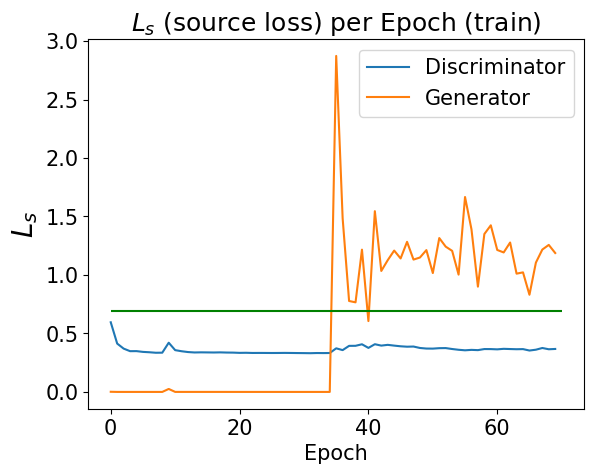

In [ ]:
plt.rcParams["font.size"] = 15
for p in ['train']:
    for g in ['discriminator', 'generator']:
        hist[p][g] = pd.DataFrame(hist[p][g], columns=['loss', 'source_loss', 'auxiliary_loss'])
        plt.plot(hist[p][g]['source_loss'], label='{} ({})'.format(g, p))

# get the NE and show as an equilibrium point
plt.hlines(-np.log(0.5), 0, hist[p][g]['source_loss'].shape[0], label='Nash Equilibrium', color='green')
plt.legend(['Discriminator', 'Generator'])
plt.title(r'$L_s$ (source loss) per Epoch (train)')
plt.xlabel('Epoch')
plt.ylabel(r'$L_s$', fontsize=20)
plt.savefig('/content/drive/MyDrive/Mani Thesis/Results_Graphs/ACGAN/Dataset2/'+ str('SourceLoss_Vs_Epoch_Train: Image_Size: ')+str(image_size)+str(' Epoch_No:')+(str(current_epoch)+'.png'))
plt.show()

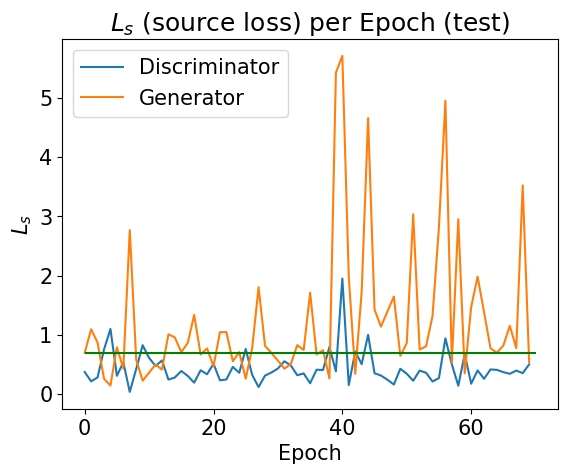

In [ ]:
for p in ['test']:
    for g in ['discriminator', 'generator']:
        hist[p][g] = pd.DataFrame(hist[p][g], columns=['loss', 'source_loss', 'auxiliary_loss'])
        plt.plot(hist[p][g]['source_loss'], label='{} ({})'.format(g, p))

# get the NE and show as an equilibrium point
plt.hlines(-np.log(0.5), 0, hist[p][g]['source_loss'].shape[0], label='Nash Equilibrium', color='green')
plt.legend(['Discriminator', 'Generator'])
plt.title(r'$L_s$ (source loss) per Epoch (test)')
plt.xlabel('Epoch')
plt.ylabel(r'$L_s$')
plt.show()

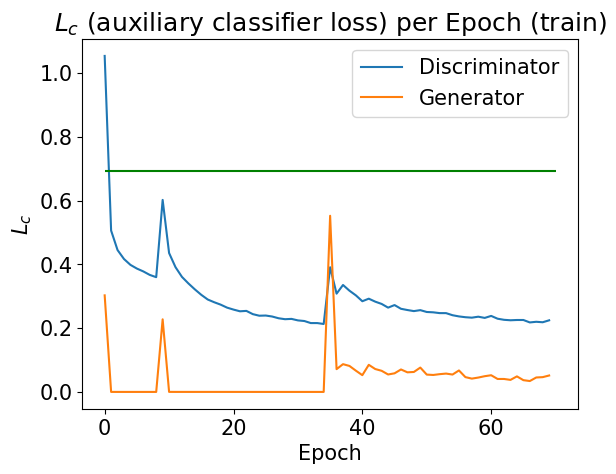

In [ ]:
for p in ['train']:
    for g in ['discriminator', 'generator']:
        hist[p][g] = pd.DataFrame(hist[p][g], columns=['loss', 'source_loss', 'auxiliary_loss'])
        plt.plot(hist[p][g]['auxiliary_loss'], label='{} ({})'.format(g, p))

plt.hlines(-np.log(0.5), 0, hist[p][g]['source_loss'].shape[0], label='Nash Equilibrium', color='green')
plt.legend(['Discriminator', 'Generator'])
plt.title(r'$L_c$ (auxiliary loss) per Epoch (train)')
plt.title(r'$L_c$ (auxiliary classifier loss) per Epoch (train)')
plt.xlabel('Epoch')
plt.ylabel(r'$L_c$')
plt.show()

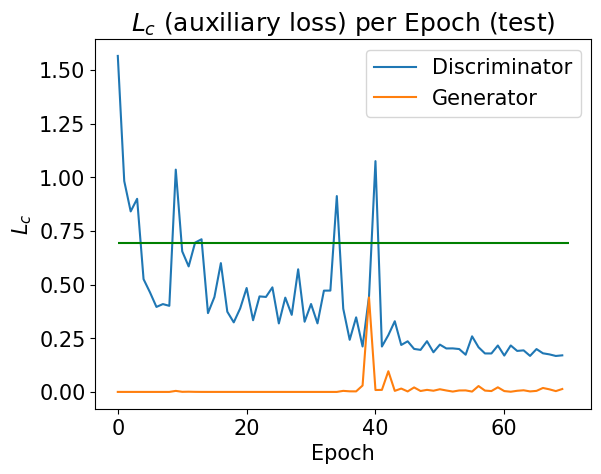

In [ ]:
for p in ['test']:
    for g in ['discriminator', 'generator']:
        hist[p][g] = pd.DataFrame(hist[p][g], columns=['loss', 'source_loss', 'auxiliary_loss'])
        plt.plot(hist[p][g]['auxiliary_loss'], label='{} ({})'.format(g, p))

plt.hlines(-np.log(0.5), 0, hist[p][g]['source_loss'].shape[0], label='Nash Equilibrium', color='green')
plt.legend(['Discriminator', 'Generator'])
plt.title(r'$L_c$ (auxiliary loss) per Epoch (test)')
plt.xlabel('Epoch')
plt.ylabel(r'$L_c$')
plt.show()

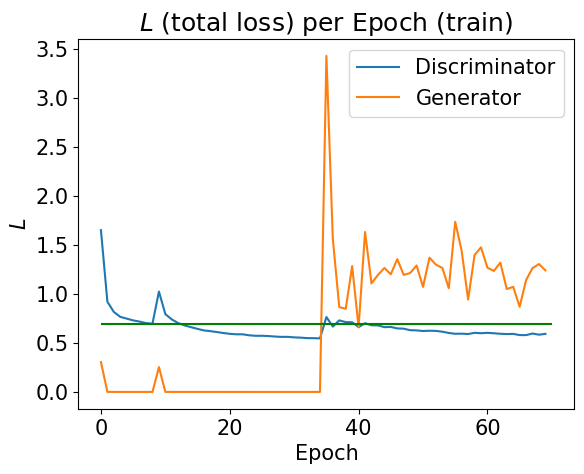

In [ ]:
for p in ['train']:
    for g in ['discriminator', 'generator']:
        hist[p][g] = pd.DataFrame(hist[p][g], columns=['loss', 'source_loss', 'auxiliary_loss'])
        plt.plot(hist[p][g]['loss'], label='{} ({})'.format(g, p))

plt.hlines(-np.log(0.5), 0, hist[p][g]['source_loss'].shape[0], label='Nash Equilibrium', color='green')
plt.legend(['Discriminator', 'Generator'])
plt.title(r'$L$ (total loss) per Epoch (train)')
plt.xlabel('Epoch')
plt.ylabel(r'$L$')
plt.show()

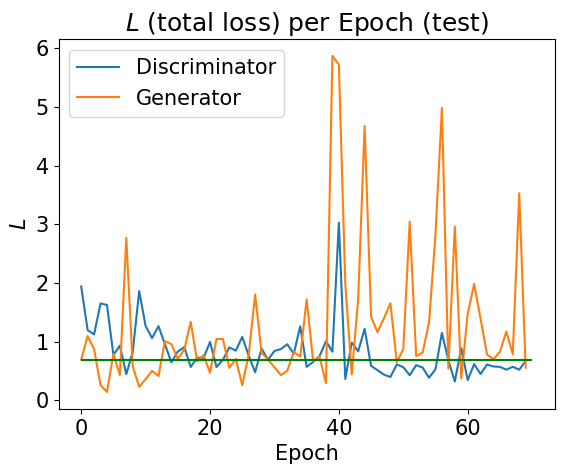

In [ ]:
for p in ['test']:
    for g in ['discriminator', 'generator']:
        hist[p][g] = pd.DataFrame(hist[p][g], columns=['loss', 'source_loss', 'auxiliary_loss'])
        plt.plot(hist[p][g]['loss'], label='{} ({})'.format(g, p))

plt.hlines(-np.log(0.5), 0, hist[p][g]['source_loss'].shape[0], label='Nash Equilibrium', color='green')
plt.legend(['Discriminator', 'Generator'])
plt.title(r'$L$ (total loss) per Epoch (test)')
plt.xlabel('Epoch')
plt.ylabel(r'$L$')
plt.show()

## Accuracy

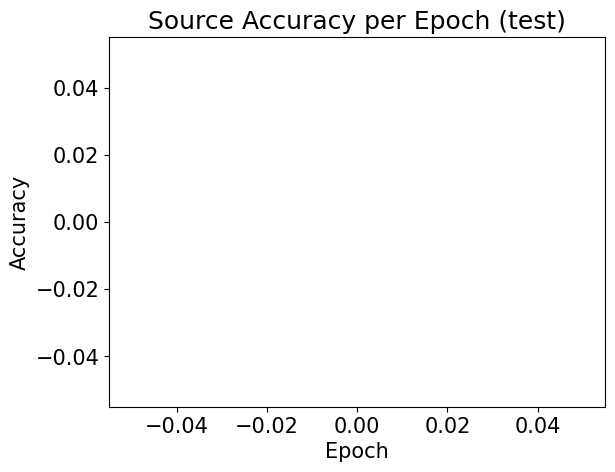

In [ ]:
plt.plot(np.mean([hist[p]['discriminator_real'], hist[p]['discriminator_fake']], axis=0), label='discriminator (mean)')
plt.title(r'Source Accuracy per Epoch (test)')
plt.xlabel('Epoch')
plt.ylabel(r'Accuracy')
plt.show()

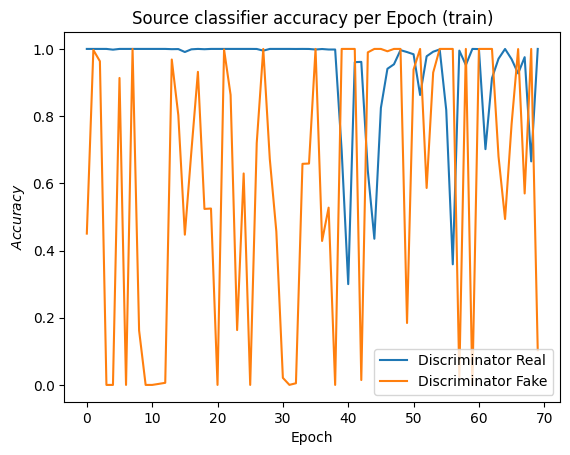

In [ ]:
plt.rcParams["font.size"] = 10
for p in ['accuracy']:
    for g in ['discriminator_real', 'discriminator_fake']:
        plt.plot(hist[p][g], label='{} ({})'.format(g, p))
    # Create a vector point-by-mean of the two accuracies vectors

plt.legend(['Discriminator Real', 'Discriminator Fake'])
plt.title(r'Source classifier accuracy per Epoch (train)')
plt.xlabel('Epoch')
plt.ylabel(r'$Accuracy$')
plt.show()

In [ ]:
def generate_batch_noise_and_labels_FID(batch_size, latent_dim, n_classes = 3):

    # generate a new batch of noise
    noise = np.random.uniform(-1, 1, (batch_size, latent_dim))

    # sample some labels
    sampled_labels = np.random.randint(0, n_classes, batch_size)

    return noise, sampled_labels

def scale_images(images, new_shape):
        images_list = list()
        for image in images:
            # resize with nearest neighbor interpolation
            new_image = resize(image, new_shape, 0)
            # store
            images_list.append(new_image)
        return asarray(images_list)

def predict_inception(model, images1, images2):
    # calculate activations
    act1 = model.predict(images1, verbose = False)
    act2 = model.predict(images2, verbose = False)
    return act1, act2

# calculate frechet inception distance
def calculate_fid(act1, act2):
    print('Calculating FID')
    print('act1 shape: ', act1.shape)
    print('act2 shape: ', act2.shape)
    # calculate mean and covariance statistics
    mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)
    # calculate sum squared difference between means
    ssdiff = np.sum((mu1 - mu2)**2.0)
    # calculate sqrt of product between cov
    covmean = sqrtm(sigma1.dot(sigma2))
    # check and correct imaginary numbers from sqrt
    if iscomplexobj(covmean):
        covmean = covmean.real
    # calculate score
    fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
    # print('FID: ', fid)
    return fid

def get_FID(generative_model, evaluation_model,
            real_images_generator, n_classes=3, n_trials=10, batch_size=400):

    FID_array = np.zeros(n_trials)
    # real_scaled_images = cv2.normalize((real_scaled_images + 1) * 127.5,
    #                                    None, alpha=0, beta=255,
    #                                    norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

    for i in range(n_trials):

        nb_batches = len(real_images_generator)

        progress_bar = Progbar(target=nb_batches)

        for index, (real_images, label_batch) in zip(range(nb_batches), real_images_generator):

            progress_bar.update(index+1) # update progress bar

            real_images = real_images / 255. # Scale from 0-255 to 0-1
            real_images = scale_images(real_images, (299,299,3))

            batch_size_real = real_images.shape[0] # ImageDataGenerator may not return a full batch
            seed_noise_rand, seed_labels_rand = generate_batch_noise_and_labels_FID(batch_size=batch_size_real, latent_dim=100)
            generated_images_sample = generative_model.predict([seed_noise_rand, seed_labels_rand.reshape((-1, 1))], verbose=0)
            # print(generated_images_sample[1])

            # if n_classes == 3:
            #     fake_images = generative_model.generator.predict([benchmarkNoise, benchmarkLabels])
            # else:
            #     fake_images = generative_model.generator.predict([benchmarkNoise])

            # fake_images_rgb = tf.image.grayscale_to_rgb(tf.convert_to_tensor(fake_images), name=None)

            generated_images_sample = (generated_images_sample + 1) / 2
            generated_images_sample = cv2.normalize(generated_images_sample,
                                            None, alpha=0, beta=1,
                                            norm_type=cv2.NORM_MINMAX,
                                            dtype=cv2.CV_32F)
            generated_images_sample = scale_images(generated_images_sample, (299,299,3))

            #print("Real image min and max: ", np.min(real_images), np.max(real_images))
            #print("Fake image min and max: ", np.min(generated_images_sample), np.max(generated_images_sample))

            if index == 0: # first batch declares the shape of the arrays
                act1_vector, act2_vector = predict_inception(evaluation_model, real_images, generated_images_sample)

            else:
                act1, act2 = predict_inception(evaluation_model, real_images, generated_images_sample)
                act1_vector = np.concatenate((act1_vector, act1), axis=0)
                act2_vector = np.concatenate((act2_vector, act2), axis=0)

        fid = calculate_fid(act1_vector, act2_vector)
        FID_array[i] = fid
        print("Trial ", i)
        print("FID: ", fid)

    mean_FID = np.mean(FID_array)
    std_FID = np.std(FID_array)

    return mean_FID, std_FID

In [ ]:
batch_size_FID = 64

In [ ]:
FID_testing_path = os.path.join(f'./Data/COVIDx-splitted-resized-{img_size}/train')

FID_testing_data = test_datagen.flow_from_directory(FID_testing_path, batch_size = batch_size_FID,
                                             target_size = (img_size, img_size),
                                             shuffle = True, class_mode = 'binary', seed = 42)
#batchx, batchy = test_data.next()
# batchx = (batchx - 127.5)/127.5	# scale to [-1, 1]
#batchx = batchx / 255. # scale to [0, 1]

FileNotFoundError: ignored

###SSIM

In [ ]:
real_dataset = ImageFolder(data_dir+'/Train', transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)]))

generated_dataset = ImageFolder(data_dir+'/Train', transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)]))

NameError: ignored

In [ ]:
import numpy as np
from skimage import measure
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

def calculate_ssim(generated_images, real_images):
    ssim_scores = []
    for gen_img, real_img in zip(generated_images, real_images):
        # Convert images to the appropriate format (e.g., uint8 or float32)
        gen_img = (gen_img * 255).astype(np.uint8)
        real_img = (real_img * 255).astype(np.uint8)

        # Calculate SSIM score
        ssim = measure.compare_ssim(gen_img, real_img, multichannel=True)

        ssim_scores.append(ssim)

    # Compute the average SSIM score
    avg_ssim = np.mean(ssim_scores)
    return avg_ssim

# Example usage with dataloaders for real and generated images
batch_size = 10
num_images = 100

# Assuming you have dataloaders for real and generated images
real_dataloader = DataLoader(real_dataset, batch_size=batch_size, shuffle=True)
generated_dataloader = DataLoader(generated_dataset, batch_size=batch_size, shuffle=True)

# Create empty lists for real and generated images
real_images = []
generated_images = []

# Iterate over real dataloader and collect images
for batch in real_dataloader:
    real_images.extend(batch)

# Iterate over generated dataloader and collect images
for batch in generated_dataloader:
    generated_images.extend(batch)

# Convert lists to NumPy arrays
real_images = np.array(real_images)
generated_images = np.array(generated_images)

# Keep the first num_images images
real_images = real_images[:num_images]
generated_images = generated_images[:num_images]

# Convert images to the appropriate format (e.g., normalize, change dimensions, etc.)
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

real_images = np.array([transform(image) for image in real_images])
generated_images = np.array([transform(image) for image in generated_images])

ssim_score = calculate_ssim(generated_images, real_images)
print("Average SSIM score:", ssim_score)
